[深度学习在线笔记](http://www.ai-start.com/dl2017)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
# from ..data.deeplearningai17761.lr_utils import load_dataset

In [14]:
def load_dataset():
    train_dataset = h5py.File('../data/deeplearningai17761/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../data/deeplearningai17761/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [17]:
# train_set_x_orig和test_set_x_orig的每一行都是代表图像的数组。
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
#  可以通过运行以下代码来可视化示例。 还可以随意更改index值并重新运行以查看其他图像

y = [1], it's a 'cat' picture.


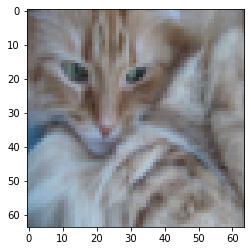

In [19]:
# Example of a picture
index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

深度学习中的许多报错都来自于矩阵/向量尺寸不匹配。 如果你可以保持矩阵/向量的尺寸不变，那么将消除大多错误。

In [21]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
# 图像尺寸
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [22]:
### 重塑训练和测试数据集，以便将大小（num_px，num_px，3）的图像展平为单个形状的向量(num_px+num_px+3, num)。
# X_flatten = X.reshape（X.shape [0]，-1）.T     ＃ 其中X.T是X的转置矩阵 当剩下的为-1时，表示剩下的数据
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten =  test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

train_set_x_flatten.shape,test_set_x_flatten.shape

((12288, 209), (12288, 50))

预处理数据集的常见步骤是：

    找出数据的尺寸和维度（m_train，m_test，num_px等）
    重塑数据集，以使每个示例都是大小为（num_px \ num_px \ 3，1）的向量
    “标准化”数据


In [33]:
# 标准化，像素值红、绿、蓝色通道（RGB），因此像素值实际上是一个从0到255的三个数字的向量
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

### 建立神经网络的主要步骤是： 1.定义模型结构（例如输入特征的数量） 2.初始化模型的参数 3.循环：

         计算当前损失（正向传播）
         计算当前梯度（向后传播）
         更新参数（梯度下降）

你通常会分别构建1-3，然后将它们集成到一个称为“ model（）”的函数中。

In [23]:
# GRADED FUNCTION: sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z
    Arguments:
    z -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(z)
    """
    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    return s

In [24]:
# 初始化参数
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim, 1))
    b = 0
    ### END CODE HERE ###
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

 ### 前向和后向传播

 正向传播：

    得到X  
    计算 A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})

计算损失函数：J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})


In [25]:
# GRADED FUNCTION: propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    m = X.shape[1]
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)            # compute activation
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A),keepdims=True)         # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    ### END CODE HERE ###
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### 优化函数

  
    初始化（w，b）
    迭代优化损失以学习参数（w，b）：
            计算损失及其梯度
            使用梯度下降更新参数
    使用学到的（w，b）来预测给定示例集的标签


In [35]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
    for i in range(num_iterations):
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        # Record the costs
        if i % 200 == 0:
            costs.append(cost)
        # Print the cost every 100 training examples
        if print_cost and i % 200 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [28]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    # for i in range(A.shape[1]):
    #     # Convert probabilities A[0,i] to actual predictions p[0,i]
    #     ### START CODE HERE ### (≈ 4 lines of code)
    #     if A[0, i] <= 0.5:
    #         Y_prediction[0, i] = 0
    #     else:
    #         Y_prediction[0, i] = 1
        ### END CODE HERE ###
    # 另一种方式
    Y_prediction[np.where(A>=0.5)]=1
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

### 将所有功能合并到模型中

In [31]:
#    Y_prediction对测试集的预测
#      Y_prediction_train对训练集的预测
#      w，损失，optimize（）输出的梯度
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):


    w,b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    # Retrieve parameters w and b from dictionary "parameters"
    w = params["w"]
    b = params["b"]
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
     # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {"costs": costs,
        "Y_prediction_test": Y_prediction_test, 
        "Y_prediction_train" : Y_prediction_train, 
        "w" : w, 
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations}

    return d

In [36]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 200: 0.466949
Cost after iteration 400: 0.331463
Cost after iteration 600: 0.279880
Cost after iteration 800: 0.242941
Cost after iteration 1000: 0.214820
Cost after iteration 1200: 0.192544
Cost after iteration 1400: 0.174399
Cost after iteration 1600: 0.159305
Cost after iteration 1800: 0.146542
Cost after iteration 2000: 0.135608
Cost after iteration 2200: 0.126137
Cost after iteration 2400: 0.117855
Cost after iteration 2600: 0.110554
Cost after iteration 2800: 0.104072
Cost after iteration 3000: 0.098280
Cost after iteration 3200: 0.093075
Cost after iteration 3400: 0.088374
Cost after iteration 3600: 0.084108
Cost after iteration 3800: 0.080219
Cost after iteration 4000: 0.076662
Cost after iteration 4200: 0.073395
Cost after iteration 4400: 0.070385
Cost after iteration 4600: 0.067604
Cost after iteration 4800: 0.065027
train accuracy: 100.0 %
test accuracy: 70.0 %


训练准确100％。 这是一个很好的情况：你的模型正在运行，并且具有足够的容量来适合训练数据。 测试误差为68％。 考虑到我们使用的数据集很小，并且逻辑回归是线性分类器，对于这个简单的模型来说，这实际上还不错。 但请放心，下周你将建立一个更好的分类器！

此外，你会看到该模型明显适合训练数据。 在本专业的稍后部分，你将学习如何减少过度拟合，例如通过使用正则化。 使用下面的代码（并更改index变量），你可以查看测试集图片上的预测。

y = 1, you predicted that it is a "cat" picture.


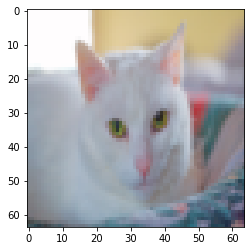

In [37]:
# Example of a picture that was wrongly classified.
index = 2
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



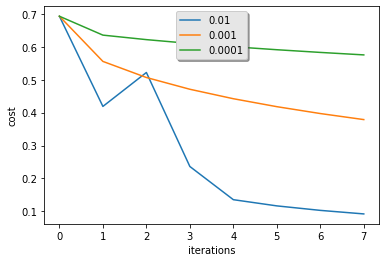

In [38]:
#  学习率 为了使梯度下降起作用，你必须明智地选择学习率。
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

y = 1.0, your algorithm predicts a "cat" picture.


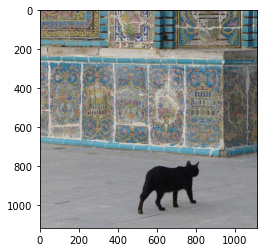

In [45]:
# 使用自己的图像进行测试
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
#my_image = "cat_in_iran.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
from skimage.transform import resize
fname = '../data/deeplearningai17761/cat_in_iran.jpg'
image = np.array(plt.imread(fname))
image.shape
# my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_image=resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")